# Forecasting with Temporian and TensorFlow Decision Forests

## Install and import dependencies


In [ ]:
%pip install temporian -q

# Optional package used by Temporian to create interactive plots.
# If if Bokeh is not installed, Temporian plots are static.
%pip install bokeh -q

# To analyse the results
%pip install seaborn -q

# To train a model
%pip install tensorflow tensorflow_decision_forests -q

# To plot the ROC curve
%pip install scikit-learn -q

In [1]:
import os
import pandas as pd
import temporian as tp
import datetime
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn import metrics as sk_metrics

2023-06-29 13:30:43.770339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 13:30:43.807114: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 13:30:43.807902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 13:30:44.629073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
start_date = datetime.date(2018, 4, 1)

#end_date = datetime.date(2018, 5, 31)
#train_test_split = "2018-04-05"

end_date = datetime.date(2018, 9, 30)
train_test_split = "2018-09-01"

filenames = []
while start_date <= end_date:
    filenames.append(f"{start_date}")
    start_date += datetime.timedelta(days=1)
print(f"{len(filenames)} dates")

183 dates


In [3]:
def load_date(filename):
    print(".",end="", flush=True)
    return pd.read_pickle(f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/main/data/{filename}.pkl")

print("Loading dataset",end="")
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    frames = executor.map(load_date, filenames)
dataset_pd = pd.concat(frames)
print("done")
print(f"Found {len(dataset_pd)} transactions")

dataset_pd

Loading dataset.......................................................................................................................................................................................done
Found 1754155 transactions


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


In [4]:
dataset_pd = dataset_pd[["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]]

In [5]:
dataset_tp = tp.from_pandas(dataset_pd, timestamps="TX_DATETIME")

dataset_tp

indexes: []
features: [('CUSTOMER_ID', str_), ('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64)]
events:
     (1754155 events):
        timestamps: [1.5225e+09 1.5225e+09 1.5225e+09 ... 1.5384e+09 1.5384e+09 1.5384e+09]
        'CUSTOMER_ID': ['596' '4961' '2' ... '618' '4056' '3542']
        'TERMINAL_ID': ['3156' '3412' '1365' ... '1502' '3067' '9849']
        'TX_AMOUNT': [ 57.16  81.51 146.   ...   6.62  55.4   23.59]
        'TX_FRAUD': [0 0 0 ... 0 0 0]
memory usage: 98.2 MB

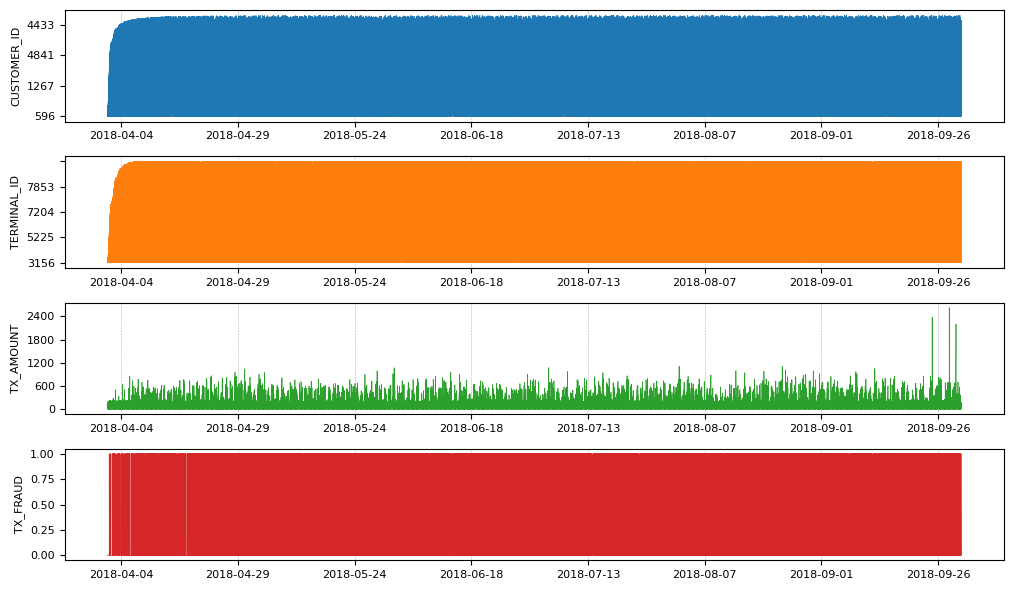

In [6]:
dataset_tp.plot()

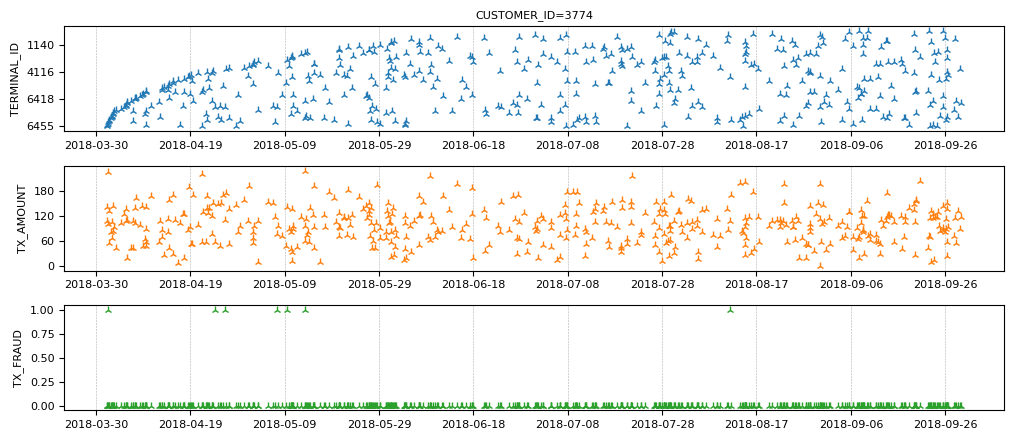

In [8]:
tp.add_index(dataset_tp.node(), "CUSTOMER_ID").run(dataset_tp).plot(max_num_plots=4, indexes="3774")

# EQ
# tp.filter(dataset_tp.node(), tp.equal(dataset_tp.node()["CUSTOMER_ID"], "3774")).run(dataset_tp).plot(max_num_plots=4)

In [9]:
x = dataset_tp.node()

per_terminal = tp.add_index(x, "TERMINAL_ID")
fraud = tp.lag(per_terminal["TX_FRAUD"], tp.duration.days(1))
feature_per_terminal = tp.moving_sum(fraud, tp.duration.weeks(4), sampling=per_terminal)
feature_per_terminal = tp.rename(feature_per_terminal, "per_terminal.moving_sum_frauds")
feature_per_terminal = tp.glue(feature_per_terminal, per_terminal)

per_customer = tp.add_index(x, "CUSTOMER_ID")
fraud = tp.lag(per_customer["TX_FRAUD"], tp.duration.days(1))
feature_per_customer = tp.moving_sum(fraud, tp.duration.weeks(4), sampling=per_customer)
feature_per_customer = tp.rename(feature_per_customer, "per_customer.moving_sum_frauds")
feature_per_customer = tp.glue(feature_per_customer, per_customer["TERMINAL_ID"])

feature_per_terminal = tp.set_index(feature_per_terminal, ["TERMINAL_ID", "CUSTOMER_ID"])
feature_per_customer = tp.set_index(feature_per_customer, ["TERMINAL_ID", "CUSTOMER_ID"])

augmented_dataset_node = tp.glue(
    feature_per_terminal, 
    tp.resample(feature_per_customer,feature_per_terminal),
)
augmented_dataset_node = tp.drop_index(augmented_dataset_node)

print(f"augmented_dataset_node:\n{augmented_dataset_node.schema}")

augmented_dataset_tp = augmented_dataset_node.run(dataset_tp)


#augmented_dataset.plot(max_num_plots=10)

# EQ
# dataset_node.add_index("CUSTOMER_ID")["TX_FRAUD"].lag(tp.duration.weeks(1)).cast(tp.float32).moving_sum(tp.duration.weeks(4))

augmented_dataset_node:
features: [('per_terminal.moving_sum_frauds', int64), ('TX_AMOUNT', float64), ('TX_FRAUD', int64), ('per_customer.moving_sum_frauds', int64), ('TERMINAL_ID', str_), ('CUSTOMER_ID', str_)]
indexes: []
is_unix_timestamp: True



In [10]:
augmented_dataset_pd = tp.to_pandas(augmented_dataset_tp)

augmented_dataset_pd

,per_terminal.moving_sum_frauds,TX_AMOUNT,TX_FRAUD,per_customer.moving_sum_frauds,TERMINAL_ID,CUSTOMER_ID,timestamp
0,0,57.16,0,0,3156,596,1.522541e+09
1,0,81.51,0,0,3412,4961,1.522541e+09
2,0,146.00,0,0,1365,2,1.522541e+09
3,0,64.49,0,0,8737,4128,1.522541e+09
4,0,50.99,0,0,9906,927,1.522541e+09
...,...,...,...,...,...,...,...
1754150,0,54.24,0,0,655,161,1.538352e+09
1754151,0,1.23,0,0,6181,4342,1.538352e+09
1754152,0,6.62,0,0,1502,618,1.538352e+09
1754153,0,55.40,0,0,3067,4056,1.538352e+09


<Axes: xlabel='per_customer.moving_sum_frauds', ylabel='Proportion'>

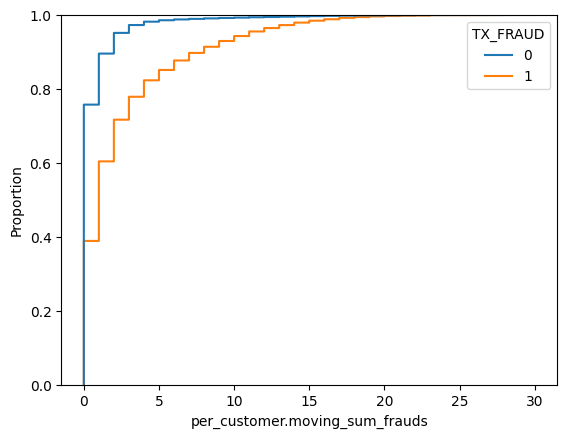

In [11]:
sns.ecdfplot(data=augmented_dataset_pd, x="per_customer.moving_sum_frauds", hue="TX_FRAUD")

<Axes: xlabel='per_terminal.moving_sum_frauds', ylabel='Proportion'>

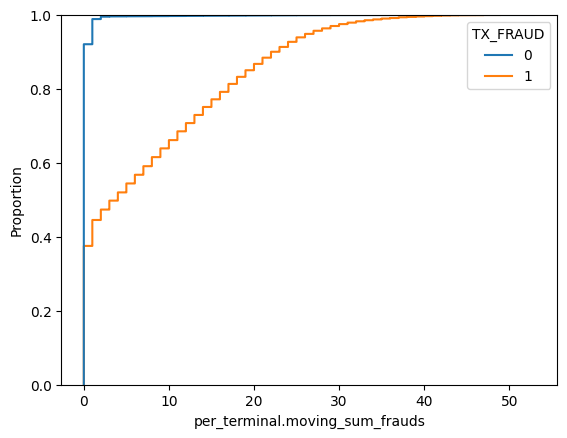

In [12]:
sns.ecdfplot(data=augmented_dataset_pd, x="per_terminal.moving_sum_frauds", hue="TX_FRAUD")

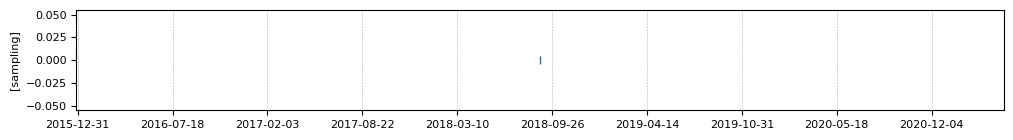

In [13]:
train_test_switch_tp = tp.event_set(timestamps=[train_test_split])
train_test_switch_tp.plot()

In [14]:
is_train_node = tp.isnan(tp.since_last(train_test_switch_tp.node(), augmented_dataset_tp.node()))
is_test_node = tp.invert(is_train_node)

augmented_dataset_train_tp = tp.filter(augmented_dataset_tp.node(), is_train_node).run([augmented_dataset_tp, train_test_switch_tp])
augmented_dataset_test_tp = tp.filter(augmented_dataset_tp.node(), is_test_node).run([augmented_dataset_tp, train_test_switch_tp])

In [15]:
augmented_dataset_train_tp.schema.features

[('per_terminal.moving_sum_frauds', int64),
 ('TX_AMOUNT', float64),
 ('TX_FRAUD', int64),
 ('per_customer.moving_sum_frauds', int64),
 ('TERMINAL_ID', str_),
 ('CUSTOMER_ID', str_)]

In [16]:
dataset_train_pd = tp.to_pandas(augmented_dataset_train_tp)
dataset_test_pd = tp.to_pandas(augmented_dataset_test_tp)

print(f"Train example: {len(dataset_train_pd)}")
print(f"Test example: {len(dataset_test_pd)}")

dataset_train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_train_pd, label="TX_FRAUD")
dataset_test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_test_pd, label="TX_FRAUD")

Train example: 1466282
Test example: 287873


2023-06-29 14:14:39.491046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-29 14:14:39.491633: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
model = tfdf.keras.GradientBoostedTreesModel(features=[tfdf.keras.FeatureUsage("per_customer.moving_sum_frauds"),
                                                       tfdf.keras.FeatureUsage("per_terminal.moving_sum_frauds"),
                                                      ],
                                             exclude_non_specified_features=True)
model.fit(dataset_train_tf,verbose=1)

Use /tmp/tmprgto1uvj as temporary training directory
Reading training dataset...


[WARNING 23-06-29 14:14:39.7333 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-29 14:14:39.7333 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-29 14:14:39.7333 CEST gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-06-29 14:14:39.799450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [1466282]
	 [[{{node Placeholder/_6}}]]


Training dataset read in 0:00:06.276430. Found 1466282 examples.
Training model...
Model trained in 0:00:30.068032
Compiling model...


[INFO 23-06-29 14:15:16.0976 CEST kernel.cc:1242] Loading model from path /tmp/tmprgto1uvj/model/ with prefix 064bb7b941d541af
[INFO 23-06-29 14:15:16.1041 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-06-29 14:15:16.1042 CEST kernel.cc:1074] Use fast generic engine
2023-06-29 14:15:16.145594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1466282]
	 [[{{node Placeholder/_0}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [18]:
test_predictions = model.predict(dataset_test_tf)[:,0]

test_predictions

2023-06-29 14:15:17.135067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [287873]
	 [[{{node Placeholder/_2}}]]


288/288 [==============================] - 1s 3ms/step


array([0.0061648 , 0.00146514, 0.00146514, ..., 0.00146514, 0.00146514,
       0.0039898 ], dtype=float32)

In [19]:
test_labels = dataset_test_pd["TX_FRAUD"].values

test_labels

array([0, 0, 0, ..., 0, 0, 0])

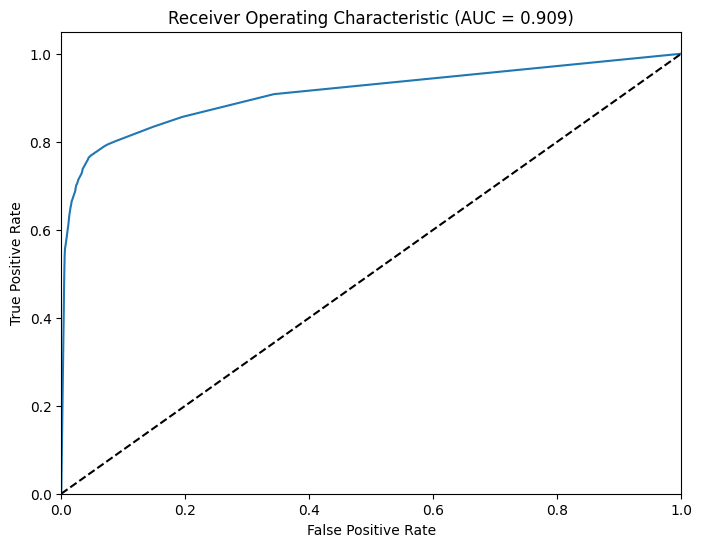

In [24]:
fpr, tpr, thresholds = sk_metrics.roc_curve(test_labels, test_predictions)
auc = sk_metrics.roc_auc_score(test_labels, test_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = %0.3f)'  % auc )
plt.show()